**Import Libraries and define Tiff File **

In [36]:
import math
import json
import sys
import pandas as pd
import rasterio
from rasterio.mask import mask
from libtiff import TIFF
import sys
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
import pickle
import h5py
import scipy.misc
import seaborn as sns
import math
import os
import matplotlib.pyplot as plt

tiffFileName='viirsDistrictLevel/India_2012-10-01_2012-10-31_500.tif'
jsonFileName='viirsDistrictLevel/Census_2011/2011_Dist.geojson'
inputFolder=tiffFileName[:-4]
if not os.path.exists(inputFolder):
    os.makedirs(inputFolder)
csv_outfile_name = inputFolder+".csv" 
csv_outfile_name1 = inputFolder+"_log.csv" 

**Break Into Districts**

In [3]:
countryData = json.loads(open(jsonFileName).read())
for currDistrictFeature in countryData["features"]:
    # currDistrictFeature=countryData["features"][0]
    distName=currDistrictFeature["properties"]['DISTRICT']
    st_cen_cd=currDistrictFeature["properties"]['ST_CEN_CD']
    censuscode=currDistrictFeature["properties"]['censuscode']
    geoms=currDistrictFeature["geometry"]
    listGeom=[]
    listGeom.append(geoms)
    geoms=listGeom
    with rasterio.open(tiffFileName) as src:
      out_image, out_transform = mask(src, geoms, crop=True)

    out_meta = src.meta.copy()

        # save the resulting raster  
    out_meta.update({"driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform})

    with rasterio.open(inputFolder+'/'+distName+'@'+str(st_cen_cd)+'@'+str(censuscode)+".tif", "w", **out_meta) as dest:
      dest.write(out_image)

**Reading all the District Files into a Dictionary**

In [2]:
onlyfiles = [f for f in listdir(inputFolder) if isfile(join(inputFolder, f))]
flattened_DataDictionary={}

In [3]:
allFlattenedArray = None
for currDFile in onlyfiles:
    #currDistrictFile='districtTiffFiles/Rajkot@24@476.tif'
    currDistrictFile=(inputFolder+'/'+currDFile)
    tif = TIFF.open(currDistrictFile, mode='r')
    image = tif.read_image()
    dataAll = np.array(image)
    flattenData=dataAll.flatten()
    flattenData=flattenData[flattenData != 0]
    flattened_DataDictionary[currDFile]=flattenData
    if (allFlattenedArray is None):
        allFlattenedArray = flattenData
    else:
        allFlattenedArray = np.append(allFlattenedArray,flattenData)

**Histogram Distribution of all the Pixels of all the states**

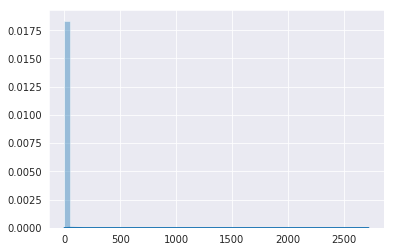

In [9]:
sns.set_style('darkgrid')
sns.distplot(allFlattenedArray)

/home/satbigvm/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(-1, 50)

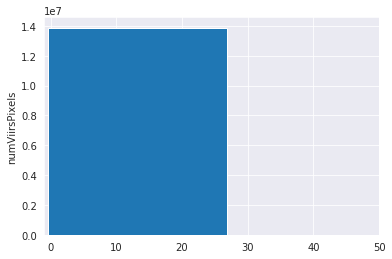

In [10]:
%matplotlib inline
plt.hist(allFlattenedArray, normed=False, bins=100)
plt.ylabel('numViirsPixels')
plt.xlim(-1,50)

In [7]:
print('Max Value :',allFlattenedArray.max())
print('Min Value :',allFlattenedArray.min())

Max Value : 2724.9485
Min Value : -0.41025564


In [8]:
checkValue=[0,0.5,1,5,10,15,20,30]
for c_check in checkValue:
    print('Percentage of Pixels greater than ',c_check,' is ',allFlattenedArray[allFlattenedArray > c_check].shape[0]*100.0/allFlattenedArray.shape[0], '%')

Percentage of Pixels greater than  0  is  99.92268939103874 %
Percentage of Pixels greater than  0.5  is  23.339678814398095 %
Percentage of Pixels greater than  1  is  9.279847219510863 %
Percentage of Pixels greater than  5  is  1.3785261011386993 %
Percentage of Pixels greater than  10  is  0.6717221995127102 %
Percentage of Pixels greater than  15  is  0.41461696842754664 %
Percentage of Pixels greater than  20  is  0.2757857521120745 %
Percentage of Pixels greater than  30  is  0.13311489059707562 %


In [9]:
tempArray=allFlattenedArray.copy()
tempArray[tempArray>10]=10
tempArray=tempArray+1.0
print('max value is :',max(tempArray))
print('min value is :',min(tempArray))
bins_1 = np.array([t/10 for t in range(102)])
binning=np.histogram(tempArray, bins=bins_1)
print(binning[0])

max value is : 11.0
min value is : 0.5897443
[      0       0       0       0       0       1       5      14     221
   10511  523784 3317971 3389778 2258510 1160765  683666  474701  343476
  256251  197283  155484  124532  101333   83627   69961   59520   51209
   44193   38526   33782   29958   27033   24045   21569   19523   17841
   16300   14990   13826   12640   11885   10980   10193    9673    8785
    8339    7734    7349    6997    6580    6152    6083    5562    5300
    5044    4855    4664    4484    4281    4047    3837    3581    3632
    3382    3262    3210    3095    2949    2880    2695    2632    2568
    2479    2468    2375    2253    2184    2093    2094    2061    2045
    2002    1815    1702    1795    1771    1694    1612    1551    1585
    1541    1515    1470    1459    1373    1320    1367    1230    1290
    1271    1186]


In [10]:
printing_dictionary={}
for key, val in flattened_DataDictionary.items():
    tempArray=val.copy()
    tempArray[tempArray>10]=10
    tempArray=tempArray+1.0
    bins_1 = np.array([t/10 for t in range(102)])
    binning=np.histogram(tempArray, bins=bins_1)
    str1=key
    str2=str1[:-4]
    distName_st_cen_cd_censuscode=str2.split('@')
    currArray=np.array([int(distName_st_cen_cd_censuscode[1]),int(distName_st_cen_cd_censuscode[2])])
    currArray=np.append(currArray,binning[0])
    printing_dictionary[distName_st_cen_cd_censuscode[0]]=currArray

In [11]:
columns1=['st_cen_cd','censuscode']
col_help=['light_'+str(t) for t in range(101)]
columns1.extend(col_help)
dataframe_districts=pd.DataFrame.from_dict(printing_dictionary, orient='index',columns=columns1)
dataframe_districts.to_csv(csv_outfile_name)

In [12]:
print(columns1)

['st_cen_cd', 'censuscode', 'light_0', 'light_1', 'light_2', 'light_3', 'light_4', 'light_5', 'light_6', 'light_7', 'light_8', 'light_9', 'light_10', 'light_11', 'light_12', 'light_13', 'light_14', 'light_15', 'light_16', 'light_17', 'light_18', 'light_19', 'light_20', 'light_21', 'light_22', 'light_23', 'light_24', 'light_25', 'light_26', 'light_27', 'light_28', 'light_29', 'light_30', 'light_31', 'light_32', 'light_33', 'light_34', 'light_35', 'light_36', 'light_37', 'light_38', 'light_39', 'light_40', 'light_41', 'light_42', 'light_43', 'light_44', 'light_45', 'light_46', 'light_47', 'light_48', 'light_49', 'light_50', 'light_51', 'light_52', 'light_53', 'light_54', 'light_55', 'light_56', 'light_57', 'light_58', 'light_59', 'light_60', 'light_61', 'light_62', 'light_63', 'light_64', 'light_65', 'light_66', 'light_67', 'light_68', 'light_69', 'light_70', 'light_71', 'light_72', 'light_73', 'light_74', 'light_75', 'light_76', 'light_77', 'light_78', 'light_79', 'light_80', 'light_81'

In [15]:
for key, val in flattened_DataDictionary.items():
    print(key)

Chandigarh@4@55.tif
Tirunelveli@33@628.tif
Udalguri@18@326.tif
Washim@27@502.tif
West Kameng@12@246.tif
Surat@24@492.tif
Baramula@1@8.tif
North Tripura@16@292.tif
Kollam@32@600.tif
Lower Subansiri@12@255.tif
Palwal@6@89.tif
Ramgarh@20@361.tif
Mirzapur@9@199.tif
Ghazipur@9@195.tif
Bikaner@8@101.tif
Mahe@34@636.tif
South@11@243.tif
Tiruvannamalai@33@606.tif
Udupi@29@569.tif
Bellary@29@565.tif
Agra@9@146.tif
Jamui@10@238.tif
Harda@23@448.tif
Sonipat@6@76.tif
Gondiya@27@507.tif
Hailakandi@18@318.tif
Churachandpur@14@274.tif
Bhopal@23@444.tif
Panchkula@6@69.tif
Sonbhadra@9@200.tif
Jhalawar@8@129.tif
South@7@98.tif
Mahendragarh@6@84.tif
Sawai Madhopur@8@108.tif
Shimla@2@33.tif
South 24 Parganas@19@343.tif
Pratapgarh@8@131.tif
Jaintia Hills@17@299.tif
Kapurthala@3@36.tif
Hisar@6@80.tif
Mandi@2@27.tif
Faridabad@6@88.tif
Hoshangabad@23@449.tif
Hoshiarpur@3@38.tif
Jodhpur@8@113.tif
Anuppur@23@461.tif
Mumbai@27@519.tif
Thiruvarur@33@619.tif
Uttara Kannada@29@563.tif
Bandipore@1@9.tif
Sabar Kantha

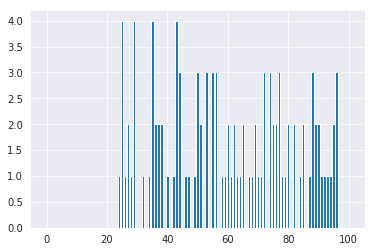

In [31]:
plt.clf()
tempArray=flattened_DataDictionary['Chandigarh@4@55.tif'].copy()
tempArray[tempArray>10]=10
tempArray=tempArray+1.0
bins_1 = np.array([t/10 for t in range(102)])
binning=np.histogram(tempArray, bins=bins_1)
x = np.arange(len(binning[0]))
plt.bar(x, binning[0])
plt.show()

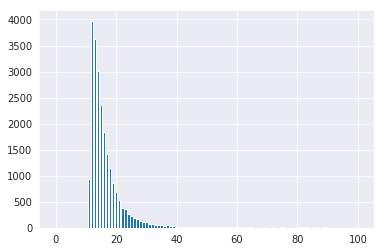

In [26]:
plt.clf()
tempArray=flattened_DataDictionary['Murshidabad@19@333.tif'].copy()
tempArray[tempArray>10]=10
tempArray=tempArray+1.0
bins_1 = np.array([t/10 for t in range(102)])
binning=np.histogram(tempArray, bins=bins_1)
x = np.arange(len(binning[0]))
plt.bar(x, binning[0])
plt.show()

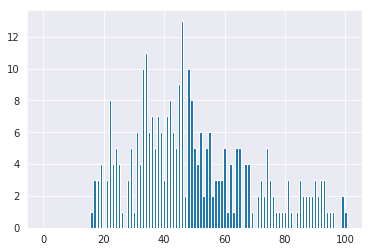

In [30]:
plt.clf()
tempArray=flattened_DataDictionary['Mumbai@27@519.tif'].copy()
tempArray[tempArray>10]=10
tempArray=tempArray+1.0
bins_1 = np.array([t/10 for t in range(102)])
binning=np.histogram(tempArray, bins=bins_1)
x = np.arange(len(binning[0]))
plt.bar(x, binning[0])
plt.show()

##  Changing to log(1+avg_rad)

In [11]:
allFlattenedArray.shape

(13907535,)

In [34]:
allFlattenedArray_log=np.log(allFlattenedArray)
allFlattenedArray_log = allFlattenedArray_log[~np.isnan(allFlattenedArray_log)]
print(allFlattenedArray_log.shape)
print("Pixels Percentage removed are",(allFlattenedArray.shape[0]-allFlattenedArray_log.shape[0])*100.0/(allFlattenedArray.shape[0]))
print('Max Value :',allFlattenedArray_log.max())
print('Min Value :',allFlattenedArray_log.min())

(13896783,)
Pixels Percentage removed are 0.07731060896125733
Max Value : 7.910205
Min Value : -15.760715


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


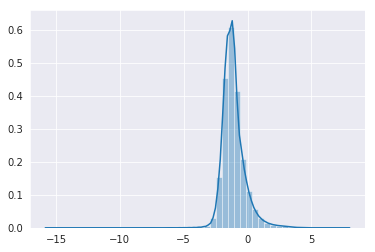

In [23]:
sns.set_style('darkgrid')
sns.distplot(allFlattenedArray_log)

In [26]:
checkValue=[-10,-8,-4,0,2,3,4,5,7]
for c_check in checkValue:
    print('Percentage of Pixels greater than ',c_check,' is ',allFlattenedArray_log[allFlattenedArray_log > c_check].shape[0]*100.0/allFlattenedArray_log.shape[0], '%')

Percentage of Pixels greater than  -10  is  99.99989206134974 %
Percentage of Pixels greater than  -8  is  99.99885585030722 %
Percentage of Pixels greater than  -4  is  99.91356992478043 %
Percentage of Pixels greater than  0  is  9.287027076698255 %
Percentage of Pixels greater than  2  is  0.9254875750740297 %
Percentage of Pixels greater than  3  is  0.27402744937443435 %
Percentage of Pixels greater than  4  is  0.03260466828905654 %
Percentage of Pixels greater than  5  is  0.0018205652344143244 %
Percentage of Pixels greater than  7  is  0.0001223304702966147 %


In [37]:
tempArray=allFlattenedArray_log.copy()
tempArray[tempArray>3]=3
tempArray[tempArray<(-4)]=-4
print('max value is :',max(tempArray))
print('min value is :',min(tempArray))
bins_1 = np.array([t/10 for t in range(-41,32)])
binning=np.histogram(tempArray, bins=bins_1)
print(binning[0])
print(binning[0].shape)

max value is : 3.0
min value is : -4.0
[     0  13689   2118   2506   2930   3587   4563   5555   7133   9220
  12507  17119  24231  35105  51389  75274 108263 153205 211106 282582
 371366 477298 587330 689658 769449 813845 826116 841187 868065 855133
 786442 685860 566362 462113 396022 352079 313919 278038 244141 213080
 186600 162513 141086 121597 104576  90481  78503  67662  59126  51104
  44578  39154  34572  30176  26680  23852  21342  18723  17009  15334
  13917  12708  11597  10640  10039   9056   8527   7753   7239   6801
   6172  38081]
(72,)


In [35]:
printing_dictionary_log={}
for key, val in flattened_DataDictionary.items():
    tempArray1=val.copy()
    tempArray2=np.log(tempArray1)
    tempArray = tempArray2[~np.isnan(tempArray2)]
    tempArray[tempArray>3]=3
    tempArray[tempArray<(-4)]=-4
    bins_1 = np.array([t/10 for t in range(-41,32)])
    binning=np.histogram(tempArray, bins=bins_1)
    str1=key
    str2=str1[:-4]
    distName_st_cen_cd_censuscode=str2.split('@')
    currArray=np.array([int(distName_st_cen_cd_censuscode[1]),int(distName_st_cen_cd_censuscode[2])])
    currArray=np.append(currArray,binning[0])
    printing_dictionary_log[distName_st_cen_cd_censuscode[0]]=currArray

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [39]:
columns1=['st_cen_cd','censuscode']
col_help=['light_'+str(t) for t in range(72)]
columns1.extend(col_help)
dataframe_districts=pd.DataFrame.from_dict(printing_dictionary_log, orient='index',columns=columns1)
dataframe_districts.to_csv(csv_outfile_name1)

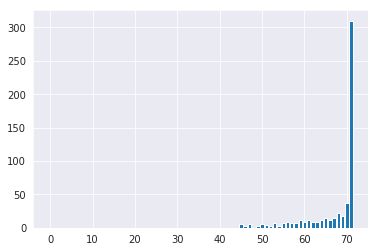

In [40]:
plt.clf()
tempArray1=flattened_DataDictionary['Chandigarh@4@55.tif'].copy()
tempArray2=np.log(tempArray1)
tempArray = tempArray2[~np.isnan(tempArray2)]
tempArray[tempArray>3]=3
tempArray[tempArray<(-4)]=-4
bins_1 = np.array([t/10 for t in range(-41,32)])
binning=np.histogram(tempArray, bins=bins_1)
x = np.arange(len(binning[0]))
plt.bar(x, binning[0])
plt.show()

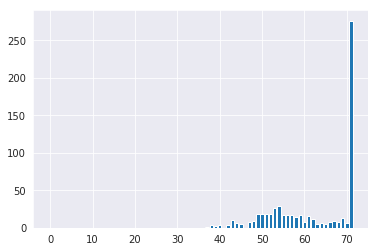

In [41]:
# ,Murshidabad@19@333.tif
plt.clf()
tempArray1=flattened_DataDictionary['Mumbai@27@519.tif'].copy()
tempArray2=np.log(tempArray1)
tempArray = tempArray2[~np.isnan(tempArray2)]
tempArray[tempArray>3]=3
tempArray[tempArray<(-4)]=-4
bins_1 = np.array([t/10 for t in range(-41,32)])
binning=np.histogram(tempArray, bins=bins_1)
x = np.arange(len(binning[0]))
plt.bar(x, binning[0])
plt.show()

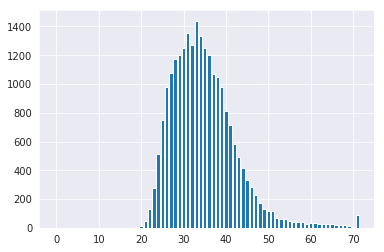

In [42]:
plt.clf()
tempArray1=flattened_DataDictionary['Murshidabad@19@333.tif'].copy()
tempArray2=np.log(tempArray1)
tempArray = tempArray2[~np.isnan(tempArray2)]
tempArray[tempArray>3]=3
tempArray[tempArray<(-4)]=-4
bins_1 = np.array([t/10 for t in range(-41,32)])
binning=np.histogram(tempArray, bins=bins_1)
x = np.arange(len(binning[0]))
plt.bar(x, binning[0])
plt.show()